# Prediccion de actividad de malware

Lucho Ago|2023 <br>
Le bonheur by Berry

- **Objetivo:** Predecir si una actividad corresponde a malware file-less (*malware*) o a un software legítimo (*goodware*).

- **Número de muestras:** 142  
  - **Malware:** 92  
  - **No Malware (Goodware):** 50

- **Número de características:** 1000

- **Tipo de problema:** Clasificación binaria supervisada

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import genfromtxt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

## Import Dataset

In [2]:
df = pd.read_csv("log_file_features.csv")
df_raw = df.copy()
df.head()

,class_name,00,000,0,46_1,20424,000214a0,00a0c91efb8b,00aa003e56f8,00c04fc295ee,...,wmiprvse,wpdbusenumroot,write,writefile,wudfhost,x86,x86_microsoft,yax,zip,zones
0,-1,17297,13218,968,5456,737,3474,5454,758,1063,...,7905,3413,16289,9830,1475,1319,1768,594,1028,1385
1,-1,7621,11138,722,5414,737,3474,3413,758,587,...,6818,3349,11804,8198,1471,1211,852,198,1016,961
2,-1,11234,10374,635,5157,738,3474,2392,758,427,...,7799,0,8467,4034,2,1203,1101,198,769,1062
3,-1,8214,9097,953,4436,60,3474,4021,758,348,...,8013,1098,9980,4733,1323,1211,907,198,810,857
4,-1,16106,10279,1027,4562,69,3474,2393,758,4862,...,7068,26,15323,5989,2,5727,1688,198,929,1285


In [3]:
df.shape

(142, 1001)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Columns: 1001 entries, class_name to zones
dtypes: int64(1001)
memory usage: 1.1 MB


In [5]:
df.describe(include="all")

,class_name,00,000,0,46_1,20424,000214a0,00a0c91efb8b,00aa003e56f8,00c04fc295ee,...,wmiprvse,wpdbusenumroot,write,writefile,wudfhost,x86,x86_microsoft,yax,zip,zones
count,142.000000,142.000000,142.000000,142.000000,142.00000,142.000000,142.000000,142.000000,142.000000,142.000000,...,142.000000,142.000000,142.00000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,-0.295775,15117.732394,7050.105634,688.274648,3212.21831,245.661972,2177.366197,2992.190141,475.084507,1615.105634,...,4913.950704,690.816901,10866.65493,5009.767606,402.943662,1211.014085,9129.077465,319.394366,637.316901,811.971831
std,0.958639,16418.504384,4740.205847,285.197210,2169.19265,320.793429,1686.199762,3012.438898,367.915780,4866.902378,...,3601.885006,1215.053976,7839.79853,5683.371411,631.216935,1429.972742,43311.280722,203.938663,478.751973,483.513514
min,-1.000000,273.000000,29.000000,197.000000,0.00000,0.000000,0.000000,780.000000,0.000000,0.000000,...,0.000000,0.000000,1545.00000,10.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,-1.000000,7055.000000,1220.500000,415.250000,521.50000,48.000000,0.000000,1070.250000,0.000000,0.000000,...,5.500000,0.000000,6181.50000,328.250000,0.000000,24.250000,266.000000,198.000000,32.250000,242.750000
50%,-1.000000,10456.500000,8871.500000,800.500000,4357.00000,59.000000,3474.000000,2415.500000,758.000000,348.000000,...,7066.500000,16.000000,10540.00000,4701.000000,2.000000,1208.000000,993.500000,210.000000,803.000000,899.000000
75%,1.000000,16208.750000,10629.500000,927.500000,5142.25000,737.000000,3474.000000,4021.000000,758.000000,852.000000,...,7910.000000,1084.000000,12777.50000,5946.750000,1323.000000,1276.000000,1339.000000,424.000000,1016.000000,1235.000000
max,1.000000,107868.000000,18992.000000,1567.000000,6751.00000,897.000000,3474.000000,32796.000000,758.000000,27151.000000,...,9388.000000,4615.000000,47198.00000,29458.000000,1475.000000,5727.000000,239928.000000,1192.000000,1973.000000,1953.000000


## Parte 1 (Sin Red)

In [6]:
# Cargar las características desde el archivo CSV (columnas 1 a 1000)
caracteristicas = genfromtxt('log_file_features.csv', delimiter=',', usecols=(i for i in range(1, 1001)), dtype=int, skip_header=1)

# Cargar los objetivos (target) desde la columna 0
objetivo = genfromtxt('log_file_features.csv', delimiter=',', usecols=(0), dtype=int, skip_header=1)

# Codificar las etiquetas
etiquetas = LabelEncoder().fit_transform(objetivo)

# Estandarizar las características
caracteristicas_std = StandardScaler().fit_transform(caracteristicas)

# Dividir en conjunto de entrenamiento y prueba
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(caracteristicas_std, etiquetas, test_size=0.25, random_state=0)

print("Inicio:__________________________________")

###################################################
## Función para imprimir métricas

def imprimir_metricas(y_verdadero, y_predicho):    
    print('Precisión (Accuracy): %.2f' % accuracy_score(y_verdadero, y_predicho))
    matriz_confusion = confusion_matrix(y_true=y_verdadero, y_pred=y_predicho)
    print("Matriz de Confusión:")
    print(matriz_confusion)
    print(pd.crosstab(y_verdadero, y_predicho, rownames=['Real'], colnames=['Predicho'], margins=True))
    print('Precisión (Precision): %.3f' % precision_score(y_true=y_verdadero, y_pred=y_predicho, average='binary'))
    print('Exhaustividad (Recall): %.3f' % recall_score(y_true=y_verdadero, y_pred=y_predicho))
    print('Medida F1: %.3f' % f1_score(y_true=y_verdadero, y_pred=y_predicho))

######################## Regresión Logística ##############################
print("######################## Regresión Logística ##############################")
clfLog = LogisticRegression()
clfLog.fit(x_entrenamiento, y_entrenamiento)
predicciones = clfLog.predict(x_prueba)
imprimir_metricas(y_prueba, predicciones)

######################## Bosque Aleatorio ##############################
print("######################## Bosque Aleatorio ##############################")
clfRandForest = RandomForestClassifier()
clfRandForest.fit(x_entrenamiento, y_entrenamiento)
predicciones = clfRandForest.predict(x_prueba)
imprimir_metricas(y_prueba, predicciones)

####################### Árbol de Decisión #######################
print("####################### Árbol de Decisión #######################")
clfDT = DecisionTreeRegressor()
clfDT.fit(x_entrenamiento, y_entrenamiento)
predicciones = clfDT.predict(x_prueba).round().astype(int)  # Redondear y convertir a entero
imprimir_metricas(y_prueba, predicciones)

####################### Naive Bayes #######################
print("####################### Naive Bayes #######################")
clfNB = GaussianNB()
clfNB.fit(x_entrenamiento, y_entrenamiento)
predicciones = clfNB.predict(x_prueba)
imprimir_metricas(y_prueba, predicciones)

Inicio:__________________________________
######################## Regresión Logística ##############################
Precisión (Accuracy): 1.00
Matriz de Confusión:
[[24  0]
 [ 0 12]]
Predicho   0   1  All
Real                 
0         24   0   24
1          0  12   12
All       24  12   36
Precisión (Precision): 1.000
Exhaustividad (Recall): 1.000
Medida F1: 1.000
######################## Bosque Aleatorio ##############################
Precisión (Accuracy): 1.00
Matriz de Confusión:
[[24  0]
 [ 0 12]]
Predicho   0   1  All
Real                 
0         24   0   24
1          0  12   12
All       24  12   36
Precisión (Precision): 1.000
Exhaustividad (Recall): 1.000
Medida F1: 1.000
####################### Árbol de Decisión #######################
Precisión (Accuracy): 1.00
Matriz de Confusión:
[[24  0]
 [ 0 12]]
Predicho   0   1  All
Real                 
0         24   0   24
1          0  12   12
All       24  12   36
Precisión (Precision): 1.000
Exhaustividad (Recall): 1.000
M

### Parte 2 (Con red)

In [7]:

tasa_aprendizaje = 0.001  
num_epocas = 5000         

In [8]:
# Codificación One-Hot

def convertir_one_hot(data):
    y_onehot = [0] * len(data)
    for i, j in enumerate(data):
        y_onehot[i] = [0] * (data.max() + 1)
        y_onehot[i][j] = 1
    return y_onehot

In [9]:
# Carga de datos

caracteristicas = genfromtxt('log_file_features.csv', delimiter=',',
                             usecols=(i for i in range(1, 1001)), dtype=float)

# Limpiar valores inválidos
caracteristicas[np.isinf(caracteristicas)] = np.nan  # Reemplaza inf y -inf por NaN
caracteristicas = np.nan_to_num(caracteristicas, nan=0.0)  # Reemplaza NaN por 0

# Leer la columna objetivo (etiqueta) como int (si estás seguro que no tiene NaN o inf)
objetivo = genfromtxt('log_file_features.csv', delimiter=',', usecols=(0), dtype=int)

In [10]:
escalador = StandardScaler()
escalador.fit(caracteristicas)
caracteristicas_normalizadas = escalador.transform(caracteristicas)


In [11]:
# Codificación de etiquetas

etiquetas_codificadas = LabelEncoder().fit_transform(objetivo)
etiquetas_onehot = convertir_one_hot(etiquetas_codificadas)


In [12]:
# División en conjunto de entrenamiento y prueba

x_entrenamiento, x_prueba, y_entrenamiento_onehot, y_prueba_onehot = \
    train_test_split(caracteristicas_normalizadas, etiquetas_onehot, test_size=0.25, random_state=0)

In [13]:
# Información del modelo

num_caracteristicas = x_entrenamiento.shape[1]
num_etiquetas = len(y_entrenamiento_onehot[0])

print(num_caracteristicas)  # Cantidad de características
print(num_etiquetas)        # Cantidad de clases
print("Inicio del entrenamiento:__________________________________")

1000
2
Inicio del entrenamiento:__________________________________


In [14]:
# Métricas

lista_precisiones = []
lista_exactitudes = []

def imprimir_metricas(y_real, y_predicho):    
    acc = accuracy_score(y_real, y_predicho)
    print('Exactitud (Accuracy): %.2f' % acc)
    lista_exactitudes.append(acc)

    matriz_confusion = confusion_matrix(y_true=y_real, y_pred=y_predicho)
    print("Matriz de Confusión:")
    print(matriz_confusion)
    print(pd.crosstab(y_real, y_predicho, rownames=['Real'], colnames=['Predicho'], margins=True))

    precision = precision_score(y_true=y_real, y_pred=y_predicho)
    print('Precisión: %.3f' % precision)
    lista_precisiones.append(precision)

    print('Exhaustividad (Recall): %.3f' % recall_score(y_true=y_real, y_pred=y_predicho))
    print('Medida F1: %.3f' % f1_score(y_true=y_real, y_pred=y_predicho))

In [15]:
# Gráfico de evolución del score

def graficar_puntaje_por_epoca():
    epocas = list(range(len(lista_exactitudes)))
    puntajes = lista_exactitudes

    plt.scatter(epocas, puntajes, s=50, c='lightgreen', marker='s', label='Exactitud')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.title('Exactitud por Época')
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
# Modelo de Red Neuronal Profunda

def capa(entrada, forma_peso, forma_sesgo):
    stddev_peso = (2.0 / forma_peso[0]) ** 0.5
    inicializador_peso = tf.random_normal_initializer(stddev=stddev_peso)
    inicializador_sesgo = tf.constant_initializer(value=0)
    W = tf.get_variable("W", forma_peso, initializer=inicializador_peso)
    b = tf.get_variable("b", forma_sesgo, initializer=inicializador_sesgo)
    return tf.nn.relu(tf.matmul(entrada, W) + b)

In [17]:
def inferencia_red_profunda(x_tf, n_caracteristicas, n_etiquetas):
    with tf.variable_scope("capa_oculta_1"):
        capa1 = capa(x_tf, [n_caracteristicas, 30], [30])
    with tf.variable_scope("capa_oculta_2"):
        capa2 = capa(capa1, [30, 25], [25])
    with tf.variable_scope("capa_oculta_3"):
        capa3 = capa(capa2, [25, 10], [10])
    with tf.variable_scope("capa_oculta_4"):
        capa4 = capa(capa3, [10, 5], [5])
    with tf.variable_scope("salida"):
        salida = capa(capa4, [5, n_etiquetas], [n_etiquetas])
    return salida


In [18]:
def funcion_perdida(salida, y_tf):
    entropia_cruzada = tf.nn.softmax_cross_entropy_with_logits(logits=salida, labels=y_tf)
    perdida = tf.reduce_mean(entropia_cruzada)
    return perdida


In [19]:
def entrenamiento(costo):
    optimizador = tf.train.GradientDescentOptimizer(tasa_aprendizaje)
    operacion_entrenamiento = optimizador.minimize(costo)
    return operacion_entrenamiento


In [20]:
def evaluar(salida, y_tf):
    prediccion_correcta = tf.equal(tf.argmax(salida, 1), tf.argmax(y_tf, 1))
    exactitud = tf.reduce_mean(tf.cast(prediccion_correcta, "float"))
    return exactitud

In [22]:
# Placeholders

# Convertir y_train_onehot y y_test_onehot en formato adecuado si aún no lo están
y_entrenamiento_cat = np.array(y_entrenamiento_onehot)
y_prueba_cat = np.array(y_prueba_onehot)

# Modelo secuencial (equivalente a tus capas densas)
modelo = Sequential([
    Dense(30, activation='relu', input_shape=(num_caracteristicas,)),
    Dense(25, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(num_etiquetas, activation='softmax')
])

# Compilar el modelo
modelo.compile(optimizer=SGD(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

C:\Users\Lupin III\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Entrenar el modelo
historial = modelo.fit(x_entrenamiento, y_entrenamiento_cat,
                       epochs=5000,
                       batch_size=32,
                       validation_data=(x_prueba, y_prueba_cat),
                       verbose=1)

Epoch 1/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.6985 - loss: 0.6402 - val_accuracy: 0.6389 - val_loss: 0.6486
Epoch 2/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6787 - loss: 0.6326 - val_accuracy: 0.6389 - val_loss: 0.6465
Epoch 3/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6987 - loss: 0.6359 - val_accuracy: 0.6389 - val_loss: 0.6440
Epoch 4/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7687 - loss: 0.6201 - val_accuracy: 0.6389 - val_loss: 0.6414
Epoch 5/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7208 - loss: 0.6197 - val_accuracy: 0.6667 - val_loss: 0.6390
Epoch 6/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7447 - loss: 0.6164 - val_accuracy: 0.6389 - val_loss: 0.6366
Epoch 7/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7270 - loss: 0.6112 - val_accuracy: 0.6389 - val_loss: 0.6341
Epoch 8/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7714 - loss: 0.5992 - val_accuracy: 0.6389 - 

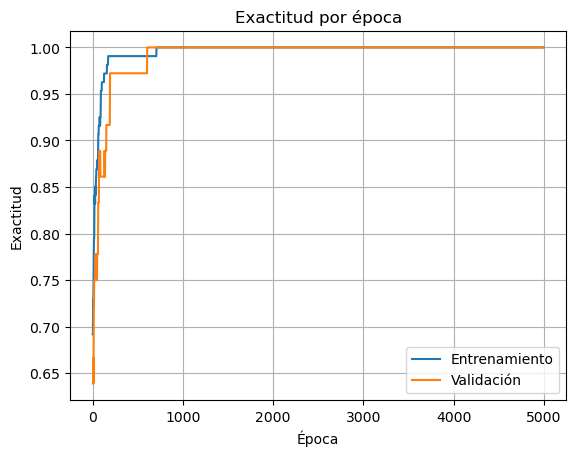

In [24]:
import matplotlib.pyplot as plt

plt.plot(historial.history['accuracy'], label='Entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.title('Exactitud por época')
plt.legend()
plt.grid(True)
plt.show()